In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from typing import List, Tuple, Dict

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.stats import multivariate_normal

# Anomaly Detection with **Probability Density Estimation**

In this notebook, we illustrate one of the simplest algorithms for **anomaly detection**, specifically an algorithm based on **probability density estimation**. First, let's introduce the problem with some basic definitions and examples. Imagine you are the owner of a company that produces airplane engines. Generally, your company performs exceptionally well, producing compliant and well-performing engines. However, in some rare cases, an engine may have small defects that can lead to significant anomalies and malfunctions. These cases are rare but possible. Preliminary analysis indicates that parameters such as temperature, fuel flow, and vibrations can help identify these defects and anomalies. Therefore, you want to set up a system to intelligently detect potential anomalies in your engines during the testing phase before selling them. This is where anomaly detection comes in! 

The idea is to examine the distribution of points (in this case, the engines) in the *feature space*, which are assumed to be numerical. "Good" engines are expected to "cluster" together, all characterized by the optimal vibrations, temperatures, and fuel flow parameters for a well-performing airplane engine. In contrast, "bad" engines are more likely to be apart in the feature space, appearing as **outliers**. If we have few features, such as 2 or 3, we may identify these outliers by simply visually inspecting the feature space. However, for more complex datasets with many features, this approach is impractical, and we need a more rigorous method. The simplest solution to this problem involves analyzing the data distribution: if data points follow a certain distribution, such as a Gaussian distribution in most cases, we can estimate this probability distribution from a sample of data points. Then, we can use this estimated probability distribution to detect outliers: if a new data point, i.e., a combination of new feature values, is expected to occur with very low probability according to the estimated distribution, we can consider that data point an "anomaly."

Suppose to have a dataset $\boldsymbol{X}$ with $M$ points $\boldsymbol{x}_i$ with $J$ features, i.e. each point is a $J$-dimensional vector $\boldsymbol{x}_i = (x_1, x_2, ..., x_J)$, distributed according to a *normal* distribution:
$$
p(\boldsymbol{x} | \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{(2\pi)^{J/2}}\frac{1}{|\boldsymbol{\Sigma}|^{1/2}} \exp \left( -\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu})^T\boldsymbol{\Sigma}^{-1}(\boldsymbol{x}-\boldsymbol{\mu})\right)
$$
where $\boldsymbol{\mu}$ and $\boldsymbol{\Sigma}$ are respectively the mean vector and the covariance matrix. We know that, in the *maximum likelihood* approach, the best estimate for the mean and covariance parameters can be obtained from the sample mean and the sample covariance, i.e.:
$$
\begin{gather}
\bar{\boldsymbol{x}} = \frac{1}{M} \sum_i^M \boldsymbol{x}_i \\
\boldsymbol{s} = \frac{1}{M-1} \sum_i^M (\boldsymbol{x}_i-\bar{\boldsymbol{x}} )(\boldsymbol{x}_i-\bar{\boldsymbol{x}})^T
\end{gather}
$$
With the sample mean and sample covariance one can thus define an *estimated probability density distribution*, i.e. $p_{est}(\bar{\boldsymbol{x}}, \boldsymbol{s})$. Such distribution represents an estimated *probability to observe a data point $\boldsymbol{x}$. Therefore, if we observe a new data point $\boldsymbol{x}_{new}$, we can compute the probability to observe such data point under the estimated distribution and reasonably assume that, if:
$$
p_{est}(\boldsymbol{x}_{new}|\bar{\boldsymbol{x}}) < \epsilon
$$
where $\epsilon$ is an arbitrary small value, then the data point is an outlier/anomaly. Of course, the ouput of the prediction strictly depends on the value $\epsilon$:
- if $\epsilon$ is too large, we are more likely to label as "outliers" data points that are actually *inliers*;
- if $\epsilon$ is too small, we are more likely to miss some outliers in our anomaly detection procedure

In this sense, $\epsilon$ can be considered as a sort of **hyperparameter** to tune, even though in the literature is rarely referred as such. In the following, we will see a rather simple but efficient technique to "tune" such parameter and find an optimal value. 

Let's try to apply this method to a sample dataset. This is not a real dataset, which in general are much more complex and with a lot of additional features. However, the purpose of this notebook is to illustrate the technique and provide hints to tackle an anomaly detection problem. Note however that most of the concepts discussed below apply equally well to real-life problems. 

## Data Exploration

When starting any machine-learning/data science problem, the first step is to perform a detailed *data exploration*. In a data exploration, we should try to understand the data dimensionality, analyze the overall data distribution, analyze each features separately and understand if any there exist any correlation between them, etc. Sometimes, a rigorous and in-depth data exploration is already sufficient to solve most of the business problem. In some more complex and particular situations, we need instead to go beyond a data exploration and apply some more advanced techniques. Neverthless, exploring data is a necessary step to get an idea of what algorithm may be the best to use to solve the problem at hand. 

Let's focus specifically on the case of anomaly detection. We are provided with a dataset (e.g., physical/mechanical parameters of airplane engines under test) with $J$ features, and we need to develop a method to spot outliers when new data become available. First, we should perform a data exploration to answer the following questions:

- Do we have numerical or categorical features?
- Do we already have data about outliers in our dataset? In other words, do we have a "label" column indicating whether already tested engines are anomalous or not?
- If the answer to the previous question is "yes," how many outliers are there in our dataset relative to the entire dataset size?

If we are working with a numerical dataset, a density estimation approach may be a good fit, especially in cases where the underlying data distribution is evident. If our dataset does not have a "label" column indicating whether a data point is an outlier, we must use an **unsupervised approach**, and a density estimation algorithm is reasonable. If, on the other hand, we do have a "label" column, we could consider using a **supervised approach**, such as training a logistic regression model or a neural network for more complex cases. In this scenario, the choice depends on the amount of data about outliers we possess: <span style="color: red;"><b>if outliers are very rare, a supervised approach may not be ideal because we need many "positive" examples for the algorithm to understand what "positive" truly means; in those cases, the "unsupervised" density estimation approach is the best choice</b></span>

With such considerations in mind, let analyze the following "toy" dataset:

In [4]:
df = pd.read_csv("../datasets/anomaly-detection-sample-dataset.csv")

In [5]:
df

,f1,f2,f3,label
0,0.827183,1.246085,0.997129,0.0
1,0.120296,1.278452,3.219158,0.0
2,-1.124642,-1.359856,1.458081,0.0
3,-0.012247,1.453384,3.127197,0.0
4,0.971571,-0.446434,4.005771,0.0
...,...,...,...,...
495,-0.759133,1.188393,0.680081,0.0
496,2.092387,0.082284,0.824211,0.0
497,0.322719,1.189017,4.235426,0.0
498,0.813517,-0.426881,1.987068,0.0


In [6]:
df.shape

(500, 4)

The dataset consists of 500 data points ($M=500$) and 4 columns. We see that the last column is a "label" indicating whether that point is an "inlier" (a **negative** example, `label=0`) or an "outlier" (a **positive** example, `label=1`). Let calculate the fraction of outliers:

In [7]:
tot_point = df.shape[0]

In [8]:
# Fraction of outliers
num_outliers = df[df["label"]==1].shape[1]

In [9]:
# Percentage outliers
perc_outliers = num_outliers/tot_point*100
print(f"The % of Outliers in this dataset is: {perc_outliers}")

The % of Outliers in this dataset is: 0.8


The outliers represent just the **0.8%** of all data points in our dataset. This is a rather small fraction, therefore a supervised learning approach to detect outliers is not a good solution. Let plot the dataset to observe if they are distributed according to a known probability distribution. Since we have 3 features, we need to plot data in 3-dimensions:

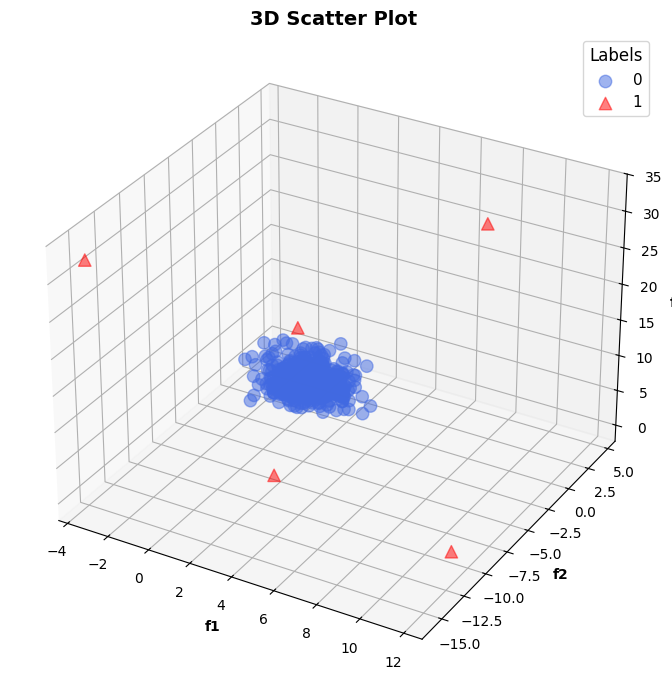

In [25]:
# Create a figure and a 3D axis
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each group separately to add a legend
for label, color, marker in zip([0, 1], ['royalblue', 'red'], ['o', '^']):
    subset = df[df['label'] == label]
    ax.scatter(subset['f1'], subset['f2'], subset['f3'], 
               c=color, marker=marker, s=80, alpha=0.5, label=f'{label}')

# Set labels and title with custom fonts
ax.set_xlabel('f1', fontsize=10, fontweight='bold')
ax.set_ylabel('f2', fontsize=10, fontweight='bold')
ax.set_zlabel('f3', fontsize=10, fontweight='bold')
ax.set_title('3D Scatter Plot', fontsize=14, fontweight='bold')

# Add a legend
ax.legend(title='Labels', title_fontsize='12', fontsize='11')

# Customize grid lines
ax.grid(color='white', linestyle='-', linewidth=1, alpha=0.7)

plt.tight_layout()
# Show the plot
plt.show()

We notice that `label=0` points, i.e. negative examples, all "live" in a limited region of the feature space and seems to form a sort of "ellipsoid", which may be indicative of a Gaussian distribution. To get a better picture of data distribution, let plot $f_i$ vs $f_j$ where $f$ denotes a feature:

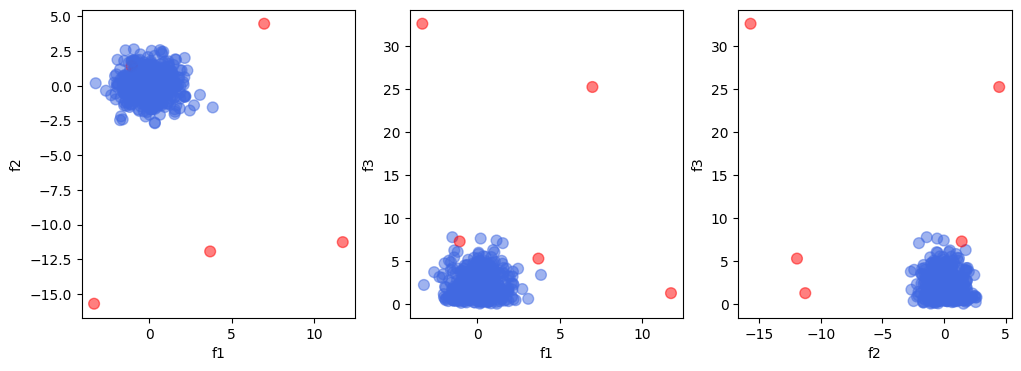

In [31]:
# Plotting features in pairs
fig, ax = plt.subplots(1, 3, figsize=(12,4))

# color code 
colors = df['label'].map({0: 'royalblue', 1: 'red'})

df.plot(kind="scatter", x='f1', y='f2', ax=ax[0], c=colors, alpha=0.5, s=60)
df.plot(kind="scatter", x='f1', y='f3', ax=ax[1], c=colors,  alpha=0.5, s=60)
df.plot(kind="scatter", x='f2', y='f3', ax=ax[2], c=colors,  alpha=0.5, s=60)

plt.show()

Focusing on "blue" dots which denote negative examples, from the first plot, we can deduce that $f_1$ and $f_2$ are likely to be distributed according to a Gaussian distribution, since data points cluster to form an "ellipse". On the other hand, $f_3$ seems to be right-skewed, with just positive values. To confirm, these findings, we can directly plot the distribution of each feature separately:

In [35]:
def sturges_bins(df_feat: pd.DataFrame) -> int:
    '''
    Using Sturge's formula to compute number of bins for normally distribtued data
    '''
    n = len(df_feat)
    return int(np.ceil(np.log2(n) + 1))

In [36]:
def sample_mean(df_feat: pd.DataFrame) -> float:
    '''
    Compute sample mean.
    '''
    
    return np.mean(df_feat)

In [37]:
def sample_variance(df_feat: pd.DataFrame) -> float:
    '''
    Compute sample variance
    '''
    
    n = len(df_feat)
    mean = sample_mean(df_feat)

    return (1/(n-1))*np.sum((df_feat-mean)**2, axis=0)

In [38]:
def gaussian(x: np.array, mean: float, s: float):
    '''
    Compute gaussian distribution

    :params x: np.array of x values
    :params mean: mean of the distribution
    :params s: variance of the distribution
    '''
    
    return (1/(np.sqrt(2*np.pi)*s))*np.exp(-(x-mean)**2/(2*s**2))

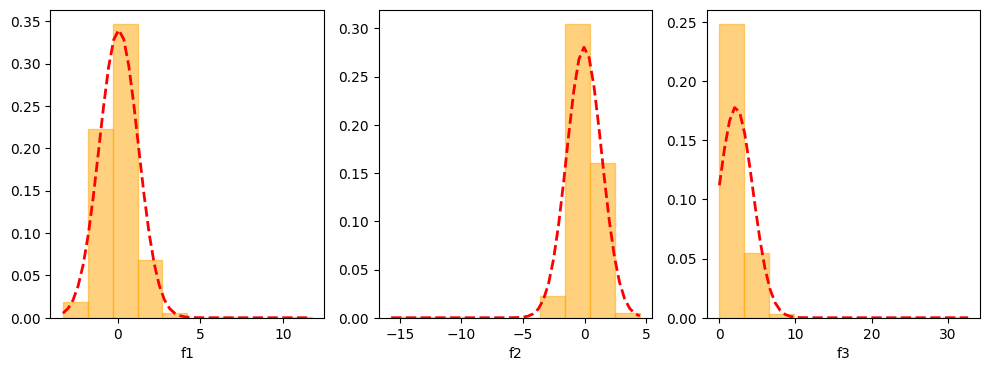

In [44]:
# Plotting each feature distribution
fig, ax = plt.subplots(1, 3, figsize=(12,4))

# For each feature, let define an array of linearly spaced x-points to plot the continuous probability distribution
x_feats = [np.linspace(min(df[i]), max(df[i])) for i in ["f1", "f2", "f3"]]
    

# For each feature, we plot the distribution using an Histogram and a number of bins obtained from the Sturge's formula.  Then, we plot a top the 
# continuous probability distribution we get from the estimated mean and variance for that feature
ax[0].hist(x=df["f1"], bins=sturges_bins(df["f1"]), color="orange", edgecolor="orange", alpha=0.5, density=True)
ax[0].plot(
    x_feats[0],
    gaussian(x_feats[0],
             sample_mean(df["f1"]), 
             np.sqrt(sample_variance(df["f1"]))), 
    color="red", lw=2, ls="--")
ax[0].set_xlabel("f1")

ax[1].hist(x=df["f2"], bins=sturges_bins(df["f2"]), color="orange", edgecolor="orange", alpha=0.5, density=True)
ax[1].plot(
    x_feats[1],
    gaussian(x_feats[1],
             sample_mean(df["f2"]), 
             np.sqrt(sample_variance(df["f2"]))), 
    color="red", lw=2, ls="--")
ax[1].set_xlabel("f2")

ax[2].hist(x=df["f3"], bins=sturges_bins(df["f3"]), color="orange", edgecolor="orange", alpha=0.5, density=True)
ax[2].plot(
    x_feats[2],
    gaussian(x_feats[2],
             sample_mean(df["f3"]), 
             np.sqrt(sample_variance(df["f3"]))), 
    color="red", lw=2, ls="--")
ax[2].set_xlabel("f3")

plt.show()

From the above plots, we can confirm that the first and second features display a Gaussian distribution. In addition, as expected, the third feature `f3` is right-skewed and strictly-positive. When some features of our dataset do not display a Gaussian distribution, we can apply some additional transformations to make them "more" normally distributed. The most common transformations are:

- applying a $\log(x)$ transformation or $\log(x+1)$ if there are some negative values between $(-1, 0]$
- square the features, i.e. computing $x^2$

For example, let apply the log transformation to feature 3:

In [40]:
df["f3"].min()

np.float64(0.0459189761095633)

In [41]:
# Copying the dataframe to a new df
df_base = df.copy()

In [42]:
# Applying the log trasformation to feature 3
df_base["f3"] = df_base["f3"].apply(lambda x: np.log(x))

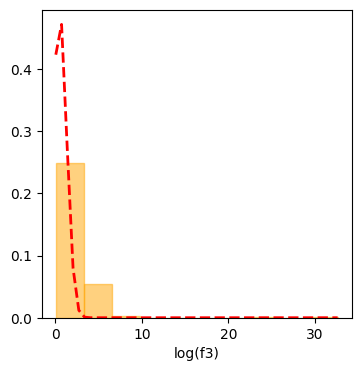

In [46]:
# Plotting each feature distribution
fig, ax = plt.subplots(figsize=(4,4))

x_f3 = np.linspace(min(df["f3"]), max(df["f3"]))

ax.hist(x=df["f3"], bins=sturges_bins(df_base["f3"]), color="orange", edgecolor="orange", alpha=0.5, density=True)
ax.plot(
    x_f3,
    gaussian(x_f3,
             sample_mean(df_base["f3"]), 
             np.sqrt(sample_variance(df_base["f3"]))), 
    color="red", lw=2, ls="--")
ax.set_xlabel("log(f3)")

plt.show()

## Data Preparation: `training`,`validation`and `test`sets

Generally, with unsupervised learning algorithms, we don't need to divide our dataset into a training and test set because we don't have any "label" to predict, so we cannot test our predictions on an existing labeled dataset. Unsupervised learning algorithms are used to identify patterns or clusters in our data without knowing in advance how to classify the data. However, in this case, we do have a label indicating whether a data point is an outlier, so we can adopt some methods typically used in supervised learning to further improve our anomaly detection algorithm.

For our purpose, we can introduce just two distinct datasets, that we call **training** and **validation** (even though we may call it *test* as well if we prefer!):

- **`training` dataset**: a training set on which we will estimate the data density distribution. Since, our goal is to get the "true" distribution of "good" examples (i.e. negative/`label=0`), this set will contain *only inliers points (label=0)*;
- **`validation` dataset**: a validation set on which we will perforrm the "hyperparameter tuning" mentioned above; indeed, this set will contain all the positive examples and it will be used to look for the best value of $\epsilon$ threshold.

In the following, we split the dataset with the following proportions: **80% of data (`label=0` only)** in the training set, and the other **20%** for the validation.

In [47]:
label0 = df_base[df_base["label"] == 0]
label1 = df_base[df_base["label"] == 1]

In [48]:
train_label0, val_label0 = train_test_split(label0, test_size=0.2, random_state=42)

In [49]:
# Combine the test set of label 0 with all data of label 1
df_val = pd.concat([val_label0, label1])

In [50]:
df_train = train_label0.copy()

In [51]:
# Check proportions
num_val = len(df_val)
num_train = len(df_train)

print(f"Proportion of X_train: {num_train/(num_val+num_train)*100}%")
print(f"Proportion of X_test: {num_val/(num_val+num_train)*100}%")

Proportion of X_train: 79.2%
Proportion of X_test: 20.8%


## Density Estimation

Now that we have both the training and validation set prepared, we need to perform two steps:
- **density estimation**: using the training set, we will compute the sample mean and sample variance, using all features. Therefore, in this specific case the sample mean will be numpy array of dimension 3, while the sample (co)variance will be a matrix of dimension 3x3
- **threshold tuning**: we will tune the value of $\epsilon$ so that the algorithm can spot outliers optimally

All the necessary code is "encapsulated" in the below Python class called `DensityEstimator`. To use this class, you just need to initialize it and set then number of steps that will be used in the following threshold tuning phase.

In [52]:
# Setting column names
feature_cols = ["f1", "f2", "f3"]
label_col = ["label"]

In [53]:
# Separating features from labels
X_train, y_train = df_train[feature_cols], df_train[label_col]
X_val, y_val = df_val[feature_cols], df_val[label_col]

In [74]:
class DensityEstimator:
    def __init__(self, n_steps=1000):
        self.n_steps = n_steps
        self.labels = np.array([['True Negative', 'False Positive'], 
                       ['False Negative', 'True Positive']]
                     )

    @staticmethod
    def estimate_gaussian(X_train: pd.DataFrame) -> Tuple[np.array]:
        '''
        Function to estimate the Gaussian distribution, computing sample mean and sample (co)variance

        :params X_train: the pandas dataframe with training features
        :returns: mean and variance
        '''
    
        # Convert to a Numpy Array
        features = X_train.to_numpy()
    
        m, n = features.shape

        # Computing mean and variance
        mean = np.mean(features, axis=0)
        variance = 1/(m+1)*np.sum((features-mean)**2, axis=0)
        
        return mean, variance

    @staticmethod
    def compute_scores(cm) -> Tuple[float]:
        '''
        A Static method to compute the precision, recall and F1 scores from a Confusion Matrix

        :params cm: the confusion matrix
        :returns: precision, recall and F1
        
        '''
        # Getting true negative (tn), false positive, false negative and true positive from cm
        tn, fp, fn, tp =  cm.ravel().tolist()

        # Computing precision
        precision = tp/(tp+fp) if tp+fp!=0 else 0 
        # Computing recall
        recall = tp/(tp+fn) if tp+fn!=0 else 0 
        # Computing F1 as the harmonic mean between precision and recall
        F1 = (2*precision*recall)/(precision+recall) if precision+recall!=0 else 0 
    
        return precision, recall, F1

    @staticmethod
    def label_prediction(pred) -> List:
        '''
        Method that convert an array of True/Positive values into 1/0
        '''
        return [1 if x else 0 for x in pred]

    def get_density_estimation(self, X_train: pd.DataFrame):
        '''
        Function returning the estimated density distribution

        :params X_train: the pandas dataframe with training features
        :returns: the estimated density distribution
        '''

        mean, variance = self.estimate_gaussian(X_train)

        self.p_density_ = multivariate_normal(mean, variance).pdf
        
        return None

    def threshold_tune(self, X_val: pd.DataFrame, y_val: pd.DataFrame):
        '''
        Function performing the threshold tuning. It tests a number of threshold value equal to n_steps,
        and for each value it computes the F1 score. The best parameter is the one with the best F1 score

        :params X_val: the Pandas dataframe with feature values from the validaton set
        :params y_val: the Pandas dataframe with labels from the validation set
        
        '''
        

        # Computing the probability of data point in the validation set
        p_val = self.p_density_(X_val.to_numpy())

        #  Setting the step size
        step_size = (max(p_val) - min(p_val)) / self.n_steps

        # Generating the array of thresholds to test
        thresholds = np.arange(min(p_val), max(p_val), step_size)

        # Generating predictions for each threshold value
        y_preds = [ self.label_prediction((p_val < threshold)) for threshold in thresholds]
    
        # Computing all confusion matrices
        cms = [confusion_matrix(y_val, y_pred) for y_pred in y_preds]

        # Computing all F1 scores
        F1_scores = [self.compute_scores(cm)[2] for cm in cms]

        # Getting the best threshold as the one with the highest F1 score
        best_param = np.argmax(np.array(F1_scores))

        self.best_params_ = {
            "threshold": thresholds[best_param], 
            "confusion_matrix": cms[best_param], 
            "F1_score": F1_scores[best_param]
        }
    
        return None

    def predict(self, X_new: pd.DataFrame):
        '''
        Method to make a new prediction given a dataframe of new points
        '''
        return self.p_density_(X_new.to_numpy())<self.best_params_["threshold"]
        

    def plot_confusion_matrix(self, cm):
        '''
        Method to plot the confusion matrx
        '''
        
        n_rows, n_columns = cm.shape[0], cm.shape[1]

        # creating annotations
        custom_annotations = np.array(
                [f'{cm[i, j]}\n{self.labels[i, j]}' for i in range(n_rows) for j in range(n_columns)]
        )
    
        fig, ax = plt.subplots(figsize=(6,6))

        # plotting confusion matrix as an heatmap
        hm = sns.heatmap(cm, 
                         annot=custom_annotations.reshape(n_rows, n_columns), 
                         annot_kws={"weight": "bold"},
                         fmt='', cmap='Blues',                      
                         xticklabels=['Predicted 0', 'Predicted 1'], 
                         yticklabels=['Actual 0', 'Actual 1'],
                         ax=ax
                        )
        ax.set_title('Confusion Matrix')
        plt.show()

In [75]:
# Initialize
my_estimator = DensityEstimator(n_steps=1000)

In [76]:
# get the estimation on the training set
my_estimator.get_density_estimation(X_train)

In [77]:
# Get the distribution: it is a class attribute
p = my_estimator.p_density_

To illustrate the outputs of this first step, let "manually" compute the probabilities on validation data points using the `p` estimated distribution:

In [78]:
p_val = p(X_val.to_numpy())

In [79]:
p_val.shape

(104,)

In [80]:
# These values are probabilities
p_val

array([1.76359386e-02, 1.19299840e-02, 2.76380479e-03, 1.44869824e-02,
       5.73570271e-03, 6.16852916e-02, 5.72898234e-03, 7.20000798e-02,
       5.64606786e-02, 3.59226778e-02, 1.46102960e-02, 3.93711992e-02,
       5.46948771e-02, 3.24928004e-02, 2.07370212e-02, 4.58301280e-02,
       1.12148132e-02, 7.91109704e-02, 5.54495861e-02, 4.72407914e-04,
       2.21433226e-02, 7.31952773e-03, 1.78074378e-02, 3.20477657e-03,
       6.07575304e-02, 4.94466680e-02, 6.92413488e-03, 6.72326077e-02,
       1.01603670e-04, 2.15444846e-03, 5.46735835e-02, 3.55644977e-02,
       1.43936581e-02, 1.46353332e-02, 6.06080288e-02, 1.73144914e-02,
       5.38689943e-02, 3.33915612e-02, 5.41431946e-02, 7.63275950e-03,
       5.77025468e-03, 5.17795838e-02, 3.09639343e-02, 1.79561443e-02,
       2.41679979e-02, 4.19165560e-02, 1.73860491e-02, 3.66856528e-02,
       2.71166029e-02, 5.47216739e-02, 1.64559333e-02, 1.69246557e-02,
       6.80963144e-03, 3.84487714e-04, 7.40002611e-02, 6.31159215e-02,
      

In [81]:
min(p_val), max(p_val)

(np.float64(1.2665178609328598e-61), np.float64(0.07911097037319098))

Now, let's set a threshold for $\epsilon$, say 0.01, and let make the predictions on the validation set:

In [82]:
epsilon = 0.01

In [83]:
pred = (p_val < epsilon)

In [84]:
pred

array([False, False,  True, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False,  True, False, False,  True,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
        True, False,  True, False, False, False, False, False, False,
        True,  True,  True,  True,  True])

`pred` is a numpy array with `True` and `False` values. "True" means that the probability of observing that point is below the defined threshold, which means that there is a little chance to observe that point. On the other hand, "False" means that the probability is higher than the threshold, hence there is an "higher" chance of observing that point. In other words, "True" corresponds to *positive* examples, or `label=1` (outliers/anomalies) while "False" corresponds to *negative* examples. Let convert the above np.array into a list of 1 and 0 and plot the so-called **`confusion_matrix`**:

In [85]:
y_pred = [1 if x else 0 for x in pred]

In [86]:
cm = confusion_matrix(y_val, y_pred)

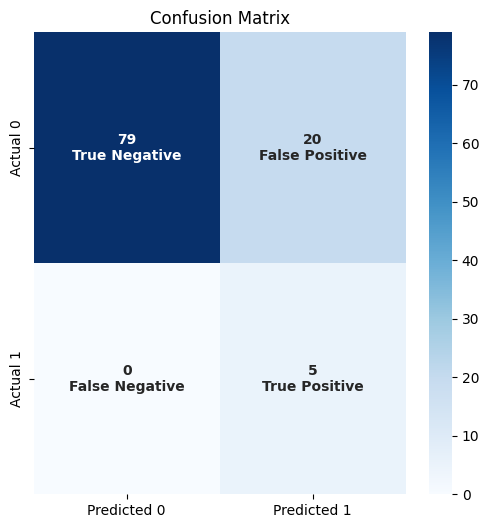

In [87]:
my_estimator.plot_confusion_matrix(cm)

The confusion matrix gives us the following information:

- with the given threshold, the number of **true positive**, i.e. datapoints predicted as "positive" (outlier) that are actually positive in the validation set, is 5. We know that in our dataset we have indeed 5 outliers. So our algorithm has correctly identified all anomalies;
- the number of **false negative**, i.e. datapoints predicted "negative" (inlier) that are actually "positive" in the validation set, is 0. Therefore, our algorithm is not missing any outliers. Wow!
- the number of **false positive**, i.e. datapoints predicted "positive" (outlier) that are actually "negative" (inlier) in the validation set, is 20. Therefore, our algorithm is classifying as anomalies 20 datapoints that are actually inliers!! This is indicative of a rather large $\epsilon$.

Ideally, we want our algorithm to have zero false negatives, zero false positives, and the highest number of true positives and true negatives. However, this is rarely achieved, so we need to find a trade-off depending on the problem at hand. In some situations, a larger number of false positives is better than a large number of false negatives. For instance, if we are predicting whether a human tissue has cancer cells, it's better to have more false positives than false negatives. This would result in more people being considered for further medical evaluation. A higher number of false negatives would have far worse consequences: many people would be considered healthy even though they actually have cancer.

A trade-off can be found by computing the so-called <span style="color: red"> <b>F1-score</b></span>. The F1 score is the harmonic mean of **precision** and **recall**:
$$
\begin{gather}
\text{precision} = \frac{TP}{TP+FP}  \\
\text{recall} = \frac{TP}{TP+FN} \\
F1 = 2\frac{\text{precision}\cdot \text{recall}}{\text{precision}+\text{recall}}
\end{gather}
$$
**Precision** represents the fraction of "relevant" positive predictions among all positive predictions; if our algorithm makes a lot of wrong positive predictions, it is likely that $FP\gg TP$, leading to a low precision. On the other hand, **recall** is measure of *sensitivity*: if our algorithm  is able to spot a large number of positive values, i.e. keeping $FN$ low, the recall increases. The F1 score is a metric that combines these measures.

Below, we use the `threshold_tune` method which performs exactly such optimization: it scans several values of the threshold paramter $\epsilon$ and compute the corresponding F1-score. The best value is the one maximizing the F1-score, i.e. the optimal balance between precision and recall:

In [88]:
my_estimator.threshold_tune(X_val, y_val)

In [89]:
# Getting threshold and confusion matrix from the best_params_ attribute
best_threshold = my_estimator.best_params_["threshold"]
best_cm = my_estimator.best_params_["confusion_matrix"]

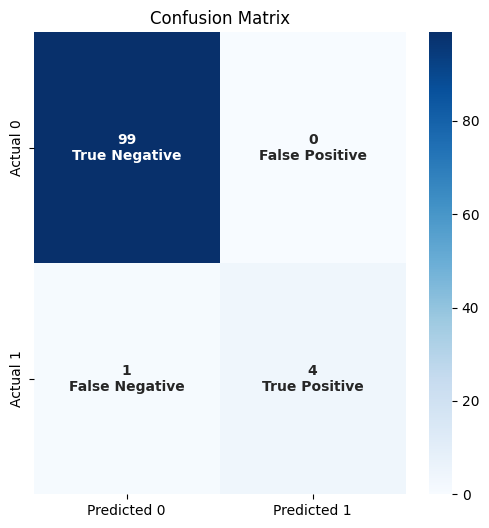

In [90]:
my_estimator.plot_confusion_matrix(best_cm)

In [93]:
print(f"The F1-score is: {my_estimator.best_params_['F1_score']}")
print(f"The best threshold epsilon: {best_threshold}")

The F1-score is: 0.888888888888889
The best threshold epsilon: 7.911097037319099e-05


We see that, after tuning, the number of false positive has dropped from 20 to 0. The "cost" of such improvement is to not correctly spot all the outliers, since the number of false negative has increased by 1. However, overall this tuned threshold leads to a better anomaly detection algorithm, with the right balance between $TP,FN,FP$.

In [95]:
# Use the predict method 
my_estimator.predict(
    pd.DataFrame([(10, 10, 10)])
)

np.True_

In [97]:
# Let apply the predict method to the validation set and see what points are predicted as outliers:
y_val_pred = my_estimator.predict(
    X_val
)

In [99]:
y_val_pred = [1 if x else 0 for x in y_val_pred]

In [103]:
df_val["pred_label"] = y_val_pred

In [104]:
df_val

,f1,f2,f3,label,pred_label
460,-1.081548,-0.966976,-0.192693,0.0,0
73,-0.275052,1.440117,-0.594531,0.0,0
314,0.751933,2.445752,-0.080532,0.0,0
175,-1.220844,0.638592,1.425191,0.0,0
337,-1.758739,1.195047,-0.127659,0.0,0
...,...,...,...,...,...
213,11.731246,-11.267675,0.243624,1.0,1
220,-3.338195,-15.708762,3.485160,1.0,1
267,-1.073021,1.429431,1.987108,1.0,0
292,6.969544,4.477169,3.229432,1.0,1


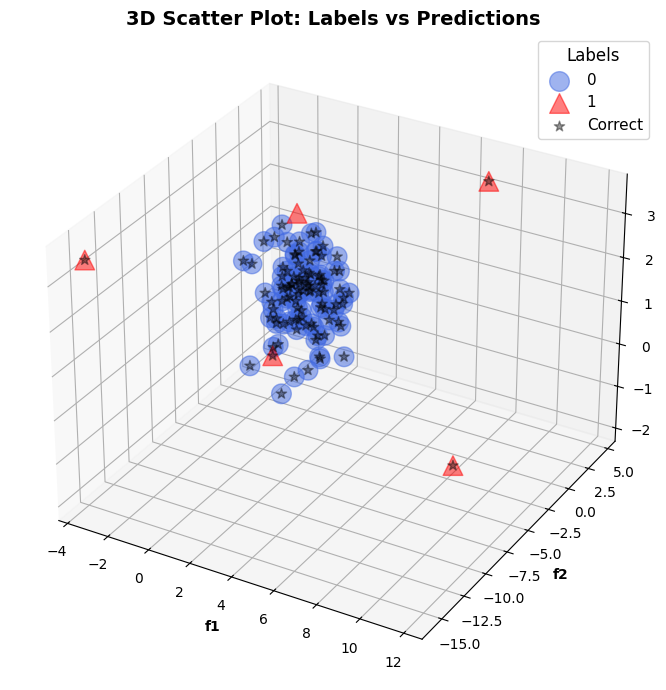

In [120]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure and a 3D axis
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each group separately to add a legend
for label, color, marker in zip([0, 1], ['royalblue', 'red'], ['o', '^']):
    subset = df_val[df_val['label'] == label]
    ax.scatter(subset['f1'], subset['f2'], subset['f3'], 
               c=color, marker=marker, s=200, alpha=0.5, label=f'{label}')

# Plot correctly predicted points with a star marker
correct_predictions = df_val[df_val['label'] == df_val['pred_label']]
ax.scatter(correct_predictions['f1'], correct_predictions['f2'], correct_predictions['f3'], 
           c='black', marker='*', s=60, alpha=0.4, label='Correct')

# Set labels and title with custom fonts
ax.set_xlabel('f1', fontsize=10, fontweight='bold')
ax.set_ylabel('f2', fontsize=10, fontweight='bold')
ax.set_zlabel('f3', fontsize=10, fontweight='bold')
ax.set_title('3D Scatter Plot: Labels vs Predictions', fontsize=14, fontweight='bold')

# Add a legend
ax.legend(title='Labels', title_fontsize='12', fontsize='11')

# Customize grid lines
ax.grid(color='white', linestyle='-', linewidth=1, alpha=0.7)

plt.tight_layout()
# Show the plot
plt.show()